# Project: Cuisine Classified
Authors: 
* Ryan Chang - rchan123
* Ryan Chandler - rchan129
* Kunal Mittal - kmitt006
* Fiorello Estuar - festu001
* Kiet Lam - klam073

# Description

This project aims to analyze the relationships between various flavors found in different foods and the cuisines that they are prominent in. 

# Reading/Cleaning Data
This section handles any cleaning/pre-processing of data such that analysis can take place.

## Reading

In [1]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import chi2_contingency
import json, os
import networkx as nx
import matplotlib.pyplot as plt

flavor_dict = {'piquant': [], 'meaty': [], 'bitter': [], 'sweet': [], 'sour': [], 'salty': []}
FLAVORS = np.array(list(flavor_dict.keys()))
CUISINES = np.array(['American','Chinese','Cuban','English','French','German','Greek','Hawaiian','Hungarian','Indian','Italian','Japanese','Mexican','Moroccan','Portuguese','Spanish','Swedish','Thai'])

In [2]:
# Reading in the data
food_list_folder = 'data/lists/'
food_list_jsons = [food_json for food_json in os.listdir(food_list_folder) if food_json.endswith('.json')]

food_df = pd.DataFrame(columns=['recipeName','ingredients','cuisine','flavors'])

for index, js in enumerate(food_list_jsons):
    with open(os.path.join(food_list_folder, js)) as food_list_file:
        food_json = json.load(food_list_file)
        num_items = len(food_json['matches'])
        for idx in range(0,num_items):
            f_obj = food_json['matches'][idx]
            f_id = f_obj['id']
            f_recipeName = f_obj['recipeName']
            f_ingredients = f_obj['ingredients']
            f_cuisine = f_obj['attributes']['cuisine']
            f_flavors = f_obj['flavors']
            food_df.loc[f_id] =  np.array([f_recipeName,f_ingredients,f_cuisine,f_flavors],dtype=object)

## Cleaning

In [3]:
# dropping all rows that do not have labels
food_df = food_df[food_df['flavors'].notna()]
food_df.head()

,recipeName,ingredients,cuisine,flavors
Revolutionary-Mac-_-Cheese-1048867,Revolutionary Mac & Cheese,"[dried pasta, milk, shredded cheddar cheese, s...","[Kid-Friendly, Italian, American]","{'piquant': 0.16666666666666666, 'meaty': 0.16..."
Chicago-Chicken-822419,Chicago Chicken,"[jalapeno chilies, lemon, dried oregano, olive...","[Barbecue, American]","{'piquant': 0.8333333333333334, 'meaty': 0.666..."
Chicken-Avocado-Burgers-1031197,Chicken Avocado Burgers,"[ground chicken, avocado, chopped garlic, pank...","[Barbecue, Mexican, American]","{'piquant': 0.6666666666666666, 'meaty': 1.0, ..."
Best-Basic-Burger-500667,Best Basic Burger,"[ground beef, eggs, salt, ground black pepper,...","[Barbecue, American]","{'piquant': 0.8333333333333334, 'meaty': 0.833..."
Easy-garlic-and-lemon-shrimp-309257,Easy Garlic and Lemon Shrimp,"[jumbo shrimp, olive oil, butter, minced garli...","[Barbecue, Italian, Asian, American]","{'piquant': 0.0, 'meaty': 0.8333333333333334, ..."


In [4]:
# clean the flavors
flavor_dict = {'piquant': [], 'meaty': [], 'bitter': [], 'sweet': [], 'sour': [], 'salty': []}
for flavors in food_df.flavors:    
    for specificFlavor in flavors:
        flavor_dict[specificFlavor].append(flavors[specificFlavor])

for flavorKey in flavor_dict:
    try:
        food_df.insert(len(food_df.columns), flavorKey, flavor_dict[flavorKey])
    except:
        pass

# food_df.drop(columns = ["flavors"], inplace=True)

In [5]:
# clean the cuisines, give each it's own column and label 0 or 1 based on presence
for cus in CUISINES:
    for key, cus_list in food_df.iterrows():
        food_df.loc[key,cus] = 1 if cus in cus_list['cuisine'] else 0
food_df.head()

,recipeName,ingredients,cuisine,flavors,piquant,meaty,bitter,sweet,sour,salty,...,Hungarian,Indian,Italian,Japanese,Mexican,Moroccan,Portuguese,Spanish,Swedish,Thai
Revolutionary-Mac-_-Cheese-1048867,Revolutionary Mac & Cheese,"[dried pasta, milk, shredded cheddar cheese, s...","[Kid-Friendly, Italian, American]","{'piquant': 0.16666666666666666, 'meaty': 0.16...",0.166667,0.166667,0.666667,0.166667,0.166667,0.833333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chicago-Chicken-822419,Chicago Chicken,"[jalapeno chilies, lemon, dried oregano, olive...","[Barbecue, American]","{'piquant': 0.8333333333333334, 'meaty': 0.666...",0.833333,0.666667,0.166667,0.000000,0.833333,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chicken-Avocado-Burgers-1031197,Chicken Avocado Burgers,"[ground chicken, avocado, chopped garlic, pank...","[Barbecue, Mexican, American]","{'piquant': 0.6666666666666666, 'meaty': 1.0, ...",0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Best-Basic-Burger-500667,Best Basic Burger,"[ground beef, eggs, salt, ground black pepper,...","[Barbecue, American]","{'piquant': 0.8333333333333334, 'meaty': 0.833...",0.833333,0.833333,0.666667,0.166667,0.166667,0.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Easy-garlic-and-lemon-shrimp-309257,Easy Garlic and Lemon Shrimp,"[jumbo shrimp, olive oil, butter, minced garli...","[Barbecue, Italian, Asian, American]","{'piquant': 0.0, 'meaty': 0.8333333333333334, ...",0.000000,0.833333,0.333333,0.166667,0.500000,0.666667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# cleaning cuisine list
food_df["cuisine"] = food_df.apply(lambda row: np.intersect1d(np.asarray(row["cuisine"]), CUISINES), axis=1)

In [7]:
#clean the ingredients
ingredientDict = {}
for ingredeintList in food_df.ingredients :
    for ingredient in ingredeintList :
        if ingredient not in ingredientDict :
            ingredientDict[ingredient] = {}

ingredientdf = pd.DataFrame.from_dict(ingredientDict, orient='index')

for index, row in food_df.iterrows() :
    for ingredient in row.ingredients :
        for flavor in row.flavors :
                if(flavor not in ingredientDict[ingredient]) :
                    ingredientDict[ingredient][flavor] = [row.flavors[flavor]]
                else :
                    ingredientDict[ingredient][flavor].append(row.flavors[flavor])

discardList = []
for ingredient in ingredientDict:
    if len(ingredientDict[ingredient]['piquant']) < 10 :
        discardList.append(ingredient)
        continue
    for flavor in ingredientDict[ingredient] :
        ingredientDict[ingredient][flavor] = sum(ingredientDict[ingredient][flavor])/len(ingredientDict[ingredient][flavor])
#print(ingredientDict)
for ingredient in discardList :
    ingredientDict.pop(ingredient)
ingredient_df = pd.DataFrame.from_dict(ingredientDict, orient='index')
ingredient_df.head()


,piquant,meaty,bitter,sweet,sour,salty
dried pasta,0.111111,0.444444,0.277778,0.177778,0.355556,0.400000
milk,0.230501,0.398793,0.415738,0.194058,0.337047,0.522052
shredded cheddar cheese,0.547074,0.442748,0.589059,0.206107,0.409669,0.625954
salt,0.266009,0.382381,0.407343,0.205210,0.445939,0.480264
dijon mustard,0.344246,0.450893,0.410714,0.208333,0.425595,0.500992


# Elementary Data Analysis

In [8]:
# cuisines
#   v1. which are the top n cuisines (frequency) in the dataset
#   v2. which cuisines have higher amounts of fusion.
#   v3. which cuisines are most blended with other cuisines (heat map?)

# flavor
#   v1. MMM - using every recipe together at first (broken down by cuisine)
#       - flavors: broken down into the 6 categories
#   v2. for each of the cuisines, visualize the flavors - spider graph
#   v3. why is hawaiian food so sweet?

# ingredients (kiet/ryan)
#   v1. MMM
#   v2. 
#   v3. 


## Cuisine

# Cuisines

In this section, we examine the relationship between the distribution of cuisines in our dataset, and any patterns we might find there.

## Proportion of Cuisines

In [9]:
### Fio's part

### Top cuisines (by frequency) in the dataset
# We create a dictionary where the keys are the names of the cuisines, and the values are the number of recipes which possess that cuisine tag.
dict_cuisine_freq = {}
for cus in CUISINES:
    dict_cuisine_freq[cus] = int(food_df[cus].sum())

# Because each recipe may have more than one cuisine tag, we cannot calculate a proportion off the total number of recipes alone because our numerator
#  would be bigger than the denominator, so we instead calculate our proportions off the total number of tags. This provides the secondary benefit of
#  having non-fusion recipes "count" for more, as they contribute less tags to the total count of recipes.
#  EX: A fusion recipe with 5 (American, Chinese, Hawaiian, Japanese, Indian) tags would only be 1/5 as meaningful to the overall proportion of chinese recipes
#        compared to a recipe with only 1 tag, Chinese.
num_tags = sum(dict_cuisine_freq.values())
# print(dict_cuisine_freq) 
# print(num_tags)


# Calculate the proportion of each cuisine across all recipes, then convert into a dataframe.
dict_proportion = {}
for cus in CUISINES:
    dict_proportion[cus] = dict_cuisine_freq[cus] / num_tags
df_proportions = pd.DataFrame(list(dict_proportion.items()), columns = ['Cuisine', 'Proportion'])

# Sort the dataframe by descending proportion
print(dict_cuisine_freq)
df_proportions.sort_values(by=['Proportion'], ascending=False, inplace=True)
df_proportions

{'American': 680, 'Chinese': 758, 'Cuban': 555, 'English': 685, 'French': 709, 'German': 790, 'Greek': 741, 'Hawaiian': 533, 'Hungarian': 509, 'Indian': 659, 'Italian': 674, 'Japanese': 549, 'Mexican': 672, 'Moroccan': 735, 'Portuguese': 214, 'Spanish': 743, 'Swedish': 462, 'Thai': 545}


,Cuisine,Proportion
5,German,0.070454
1,Chinese,0.067600
15,Spanish,0.066262
6,Greek,0.066084
13,Moroccan,0.065549
4,French,0.063230
3,English,0.061090
0,American,0.060644
10,Italian,0.060109
12,Mexican,0.059930


### Visualization

In [10]:
# Visualization for Cuisine proportion
# TODO: Reverse order, find ways to color it nicer.
fig_proportion = go.Figure(go.Bar(
    x = df_proportions['Proportion'].tolist(),
    y = df_proportions['Cuisine'].tolist(),
    orientation = 'h'))
fig_proportion.show()

### Analysis
From this part of our EDA, we can see that, surprisingly, German cuisine represents the largest proportion of recipes in our dataset (at 7%). This was completely unexpected, as we would predict that the most "internationally known" cuisines such as American, Chinese, etc would dominate the list.

Our top 5 cuisines were...
1. German (7.05%)
2. Chinese (6.76%)
3. Spanish (6.63%)
4. Greek (6.61%)
5. Moroccan (6.55%)

Based on how we calculated our proportion, we have an idea of how this could've happened. Because the total we're calculating our proportion out of is the number of total cuisine tags that appear (of which each recipe can have multiple), a recipe with multiple tags contributes less to each of its cuisine tags' overall proportion in the dataset. Therefore, even though the tag for "American" cuisine is quite prevalent, it is likely a smaller overall proportion of the total tags as recipes with "American" cuisine tags tend to have other cuisine tags with them as well due to the diverse nature of American cuisine. Conversely, German cuisine is much more "traditional" than American cuisine and thus would have fewer extra tags for German recipes, which means that the German recipes make up a much larger total proportion.

## The Question of Fusion Cuisine...

As we noticed above, it seems that certain cuisines were unexpectedly far more represented proportionally compared to others despite our initial prediction. To explore this, we decided to calculate for each given cuisine tag, the average number of other cuisine tags it was paired with. 

In [11]:
food_df.head()

,recipeName,ingredients,cuisine,flavors,piquant,meaty,bitter,sweet,sour,salty,...,Hungarian,Indian,Italian,Japanese,Mexican,Moroccan,Portuguese,Spanish,Swedish,Thai
Revolutionary-Mac-_-Cheese-1048867,Revolutionary Mac & Cheese,"[dried pasta, milk, shredded cheddar cheese, s...","[American, Italian]","{'piquant': 0.16666666666666666, 'meaty': 0.16...",0.166667,0.166667,0.666667,0.166667,0.166667,0.833333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chicago-Chicken-822419,Chicago Chicken,"[jalapeno chilies, lemon, dried oregano, olive...",[American],"{'piquant': 0.8333333333333334, 'meaty': 0.666...",0.833333,0.666667,0.166667,0.000000,0.833333,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chicken-Avocado-Burgers-1031197,Chicken Avocado Burgers,"[ground chicken, avocado, chopped garlic, pank...","[American, Mexican]","{'piquant': 0.6666666666666666, 'meaty': 1.0, ...",0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Best-Basic-Burger-500667,Best Basic Burger,"[ground beef, eggs, salt, ground black pepper,...",[American],"{'piquant': 0.8333333333333334, 'meaty': 0.833...",0.833333,0.833333,0.666667,0.166667,0.166667,0.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Easy-garlic-and-lemon-shrimp-309257,Easy Garlic and Lemon Shrimp,"[jumbo shrimp, olive oil, butter, minced garli...","[American, Italian]","{'piquant': 0.0, 'meaty': 0.8333333333333334, ...",0.000000,0.833333,0.333333,0.166667,0.500000,0.666667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
### Creating setup for next EDA...

### Keeping a set of all cuisines 
set_cuisines = set(CUISINES)

#print(set_cuisines)

### Dictionary of dictionaries - example: {American: {chinese : 2,  german: 3}, Chinese: {American: 2, German: 5}, ... }
#   First layer: The keys are the individual cuisines, and each cuisine's value is another dictionary, containing the number of times it is paired with each other cuisine.
#       Second layer: The keys are all the cuisines except for the one that is the key for this dictionary, and the values are the amount of time the layer 1 key is paired with this cuisine 
#   
# Constructing dict_cuisine_pairings and dict_pairing_subsets
dict_cuisine_pairings = {}
dict_pairing_subsets = {}
for cus in CUISINES:
    # For each upper cuisine key, create another dictionary with the 17 other cuisine keys as its lower keys and the number of times the upper key is paired with
    # the other lower keys as the values.
    dict_cuisine_pairings[cus] = {} 
    dict_pairing_subsets[cus] = set()
    for cus2 in CUISINES:
        if (cus != cus2):
            dict_cuisine_pairings[cus][cus2] = 0
            dict_pairing_subsets[cus].add(frozenset([cus, cus2]))

#print(dict_cuisine_pairings)
print(dict_pairing_subsets)



{'American': {frozenset({'Indian', 'American'}), frozenset({'German', 'American'}), frozenset({'Hungarian', 'American'}), frozenset({'English', 'American'}), frozenset({'Italian', 'American'}), frozenset({'Mexican', 'American'}), frozenset({'Thai', 'American'}), frozenset({'Chinese', 'American'}), frozenset({'Swedish', 'American'}), frozenset({'French', 'American'}), frozenset({'Greek', 'American'}), frozenset({'Cuban', 'American'}), frozenset({'Moroccan', 'American'}), frozenset({'Japanese', 'American'}), frozenset({'Spanish', 'American'}), frozenset({'Portuguese', 'American'}), frozenset({'Hawaiian', 'American'})}, 'Chinese': {frozenset({'Chinese', 'Spanish'}), frozenset({'Chinese', 'German'}), frozenset({'Chinese', 'Hungarian'}), frozenset({'English', 'Chinese'}), frozenset({'Chinese', 'Indian'}), frozenset({'Italian', 'Chinese'}), frozenset({'Chinese', 'Mexican'}), frozenset({'Chinese', 'Swedish'}), frozenset({'French', 'Chinese'}), frozenset({'Chinese', 'Thai'}), frozenset({'Chine

In [13]:
# TODO: Change from head to whole dataframe after testing algorithm.
from itertools import combinations

#curr_cuisines_pairs = []
for i, row in food_df.iterrows():
    curr_cuisines = food_df.loc[i].at['cuisine']
    #curr_cuisines_pairs.append(list(combinations(curr_cuisines, 2)))

#print(curr_cuisines) ## Remove me later
#curr_cuisines_pairs = list(filter(None, curr_cuisines_pairs))
#print(curr_cuisines_pairs)

    #for key in dict_pairing_subsets:
        #if dict_pairing_subsets[key].issubset(curr_cuisines):
            #print('DEBUG: dict_pairing_subsets[key].issubset(curr_cuisines) is ', dict_pairing_subsets[key].issubset(curr_cuisines))
            #dict_cuisine_pairings[key]

In [14]:
graph_cuisines = nx.Graph()
graph_cuisines.add_nodes_from(CUISINES)
print(graph_cuisines.nodes)

curr_cuisines_pairs = []
for i, row in food_df.iterrows():
    curr_cuisines = food_df.loc[i].at['cuisine']
    curr_cuisines_pairs = list(filter(None, list(combinations(curr_cuisines, 2))))

    #print('curr_cuisines:', curr_cuisines)
    #print('curr_cuisine_pairs:', curr_cuisines_pairs)

    if len(curr_cuisines_pairs) > 0: 
        #print('pairs detected') ## DEBUG

        for pair in curr_cuisines_pairs:
            curr_pair = list(pair)
            cus1 = curr_pair[0] 
            cus2 = curr_pair[1]

            if (graph_cuisines.has_edge(cus1, cus2)) == False:
                graph_cuisines.add_edge(cus1, cus2, weight = 1)
                ## print("Adding edge: (" + str(cus1 + ' ' + cus2 + "), initialized to weight = 1")) ## DEBUG

            else:
                graph_cuisines.edges[cus1, cus2]["weight"] = graph_cuisines.edges[cus1, cus2]["weight"] + 1
                ## print("Edge (" + str(cus1) + ' ' + str(cus2) + ") already exists, weight incremented to", str(graph_cuisines.edges[cus1, cus2]["weight"])) ## DEBUG

    ## DEBUG
    #else: 
        # print('no pairs') 
    
#print(graph_cuisines.edges)
#print(graph_cuisines.adj)
#print(graph_cuisines.number_of_edges("American", "Italian")) ## <- Returns 2 for head, since there are 2 (American, Italian) pairings there.

['American', 'Chinese', 'Cuban', 'English', 'French', 'German', 'Greek', 'Hawaiian', 'Hungarian', 'Indian', 'Italian', 'Japanese', 'Mexican', 'Moroccan', 'Portuguese', 'Spanish', 'Swedish', 'Thai']


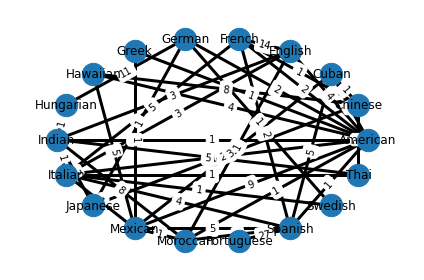

In [53]:
## Visualization of the graph calculated above using matplotlib-pyplot

# Spring layout 
pos = nx.circular_layout(graph_cuisines)

# Draw the nodes and edges
nx.draw_networkx_nodes(graph_cuisines, pos, node_size=500)
nx.draw_networkx_edges(graph_cuisines, pos, width=3)

# Draw node labels
nx.draw_networkx_labels(graph_cuisines, pos, font_size=12, font_family="sans-serif")

# Draw edge weights
edge_labels = nx.get_edge_attributes(graph_cuisines, "weight")
nx.draw_networkx_edge_labels(graph_cuisines, pos, edge_labels)

# Put it all together
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.tight_layout()
plt.show()

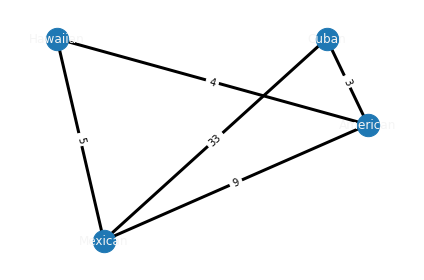

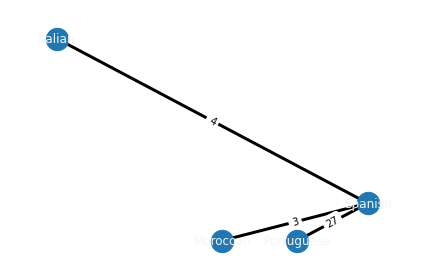

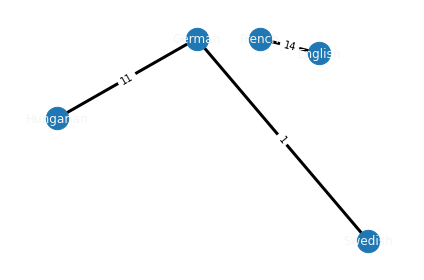

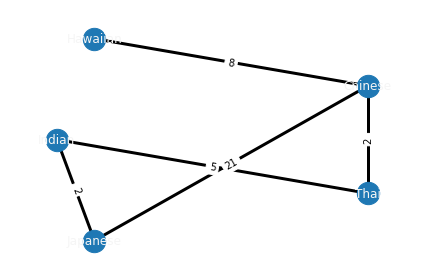

In [61]:
# Breaking the graph up into smaller ones by region.
# NOTE: Some cuisines were made to appear in multiple regions, due  to the potential of crossover 
graph_americas = graph_cuisines.subgraph(["Hawaiian","American","Mexican","Cuban"]).copy()
graph_south_europe = graph_cuisines.subgraph(["Italian","Portuguese","Spanish","Moroccan"]).copy()
graph_north_europe = graph_cuisines.subgraph(["English","French","German","Hungarian","Swedish"]).copy()
graph_asia = graph_cuisines.subgraph(["Indian","Thai","Chinese","Japanese", "Hawaiian"]).copy()

def drawGraph(input_graph):
    # Layout
    position = nx.planar_layout(input_graph)
    # Draw the nodes and edges
    nx.draw_networkx_nodes(input_graph, pos, node_size=500)
    nx.draw_networkx_edges(input_graph, pos, width=3)
    # Draw node labels
    nx.draw_networkx_labels(input_graph, pos, font_size=12, font_family="sans-serif", font_color="whitesmoke")
    # Draw edge weights
    edge_labels = nx.get_edge_attributes(input_graph, "weight")
    nx.draw_networkx_edge_labels(input_graph, pos, edge_labels)
    # Draw graph
    ax = plt.gca()
    ax.margins(0.1)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

drawGraph(graph_americas)
drawGraph(graph_south_europe)
drawGraph(graph_north_europe)
drawGraph(graph_asia)

##  Flavor

In this section, we aim to examine flavors of a given recipe, and any patterns that may exist within each flavor, or it's predicitve power over the various cuisines.

In [16]:
# flavors, and flavor averages
flavor_fig = go.Figure()
for flav in FLAVORS:
    flavor_fig.add_trace(go.Violin(
        y=food_df[flav],
        name=flav,
    ))
flavor_fig.update_layout(
    title_text="Flavors, Visualized"
)
flavor_fig.show()

This visualization shows the distribution of flavors in the various dishes. From this plot, we can see that the flavors were rated on a scale from 1-7, as demonstrated by the spikes in the violin chart. The data tends to be skewed towards the ends; recipes tended to either have an abundance of a flavor, or almost entirely lack it. Consequently, there is significantly less data towards the centers of each flavor spectrum.

Deeper analysis of the flavors in the contexts of different independent variables may allow us to unveil hidden patterns that exist among the various flavor categories.

### Cuisines vs. Flavors

In [17]:
# manually creating pivot table
cuisine_flavor = pd.DataFrame(columns=FLAVORS,index=CUISINES)
for cus in CUISINES:
    for f in FLAVORS:
        cuisine_flavor.loc[cus,f] = food_df.loc[food_df[cus]==1,f].mean()
cuisine_flavor['magnitude'] = cuisine_flavor[FLAVORS].sum(axis=1)/6

In [18]:
# cusines vs. flavors
region_grouping = [
    ["Hawaiian","American","Mexican","Cuban"],
    ["Italian","Portuguese","Spanish","Moroccan"],
    ["English","French","German","Hungarian","Swedish"],
    ["Indian","Thai","Chinese","Japanese"]
]
for group in region_grouping:
    group = sorted(group,key=lambda x: cuisine_flavor.loc[x,"magnitude"])
specs_list = []
for i in range (0,1):
    specs_list.append([])
    for j in range(0,2):
        specs_list[i].append({"type":"polar"})
fig1t = make_subplots(rows=1,cols=2,specs=specs_list,subplot_titles=('Americas','Southern Europe'))
group_num = 0
for i in range(0,2):
    for cuisine in region_grouping[group_num]:
        fig1t.append_trace(
            go.Scatterpolar(
                r=cuisine_flavor.loc[cuisine],
                theta=FLAVORS,
                fill='toself',
                name=cuisine
            ),row=1,col=i+1
        )
    group_num += 1
fig1b = make_subplots(rows=1,cols=2,specs=specs_list,subplot_titles=('Northern Europe','Asia'))
for i in range(0,2):
    for cuisine in region_grouping[group_num]:
        fig1b.append_trace(
            go.Scatterpolar(
                r=cuisine_flavor.loc[cuisine],
                theta=FLAVORS,
                fill='toself',
                name=cuisine
            ),row=1,col=i+1
        )
    group_num += 1
fig1t.update_layout(
    title_text="Cuisine vs. Flavor",
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0,0.75]
        )
    ),
)
fig1b.update_layout(
    title_text="Cuisine vs. Flavor",
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0,0.75]
        )
    ),
)
fig1t.show()
fig1b.show()

To visualize the flavors present in these various cuisines, we use a spider graph to compare the varying flavor qualities between cuisines. Since there were 18 regions defined in this dataset, it would prove inefficient to overlay all 18 spider charts over eachother. Instead, we proceed by creating separate subgraphs for 4 geographical regions: Americas, Southern Europe, Northern Europe, and Asia. 

Within the cuisines geographically close to the Americas, we can see that there is a high variety of flavors in this region. It is interesting to note that Mexican cuisine is significantly more 'piquant' or 'spicy' than it's neighbouring cuisines. Hawaiian cuisine boasts having the sweetest recipes, with the second highest belonging to Chinese cuisine.

In the Asian cuisines, it is interesting to note that on average, the Asian recipies tended to be significantly more salty and bitter than in other cuisines. Furthermore, Japanese and Chinese cuisines appear to encompass very similar flavors, having similar values in all flavor qualities. 

On the contrary, we can see that cuisines belonging to the Northern European regions did not introduce flavors that were as vibrant as Asian recipes. Unlike in the Americas (where flavors were varied), Northen European flavors tended to stay more-or-less similar between cuisines.

Finally, in Southern European Cuisines, the flavor charts tended to depict similar flavor structures, with high sour levels, but lower salt levels. However, we can see that Italian cuisine is very different from typical Southern European cuisine; rather it resembles a flavor structure similar to Japanese or Chinese cuisine boasting high levels of salty and bitter flavors, and lower levels of piquant and sour flavors. Italian flavors being similar to Asian flavors could be a result of the exchange of ideas/ingredients which occured across the Silk Road.

### Region vs. Flavor

In [19]:
# 3D Scatter Plot, Recipe vs. Cuisine
# TODO: fix legend labels (has to do with order you add countries to the trace), add title
fig2sub = make_subplots(rows=1,cols=2,specs=[[{'type':'scene'},{'type':'scene'}]])
fig2left = go.Figure(data=[
    go.Scatter3d(
        x=cuisine_flavor.loc[region_grouping[0]]['sweet'],
        y=cuisine_flavor.loc[region_grouping[0]]['sour'],
        z=cuisine_flavor.loc[region_grouping[0]]['salty'],
        text=cuisine_flavor.loc[region_grouping[0]].index,
        mode='markers',
        name='Americas',
        legendgroup='g1',
        marker=dict(
            size=10,
            color="#F51663"
        )
    ),
    go.Scatter3d(
        x=cuisine_flavor.loc[region_grouping[1]]['sweet'],
        y=cuisine_flavor.loc[region_grouping[1]]['sour'],
        z=cuisine_flavor.loc[region_grouping[1]]['salty'],
        text=cuisine_flavor.loc[region_grouping[1]].index,
        mode='markers',
        name='Southern Europe',
        legendgroup='g2',
        marker=dict(
            size=10,
            color="#DEB3AD"
        )   
    ),
    go.Scatter3d(
        x=cuisine_flavor.loc[region_grouping[2]]['sweet'],
        y=cuisine_flavor.loc[region_grouping[2]]['sour'],
        z=cuisine_flavor.loc[region_grouping[2]]['salty'],
        text=cuisine_flavor.loc[region_grouping[2]].index,
        mode='markers',
        name='Northern Europe',
        legendgroup='g3',
        marker=dict(
            size=10,
            color="#FAC218"
        )
    ),
    go.Scatter3d(
        x=cuisine_flavor.loc[region_grouping[3]]['sweet'],
        y=cuisine_flavor.loc[region_grouping[3]]['sour'],
        z=cuisine_flavor.loc[region_grouping[3]]['salty'],
        text=cuisine_flavor.loc[region_grouping[3]].index,
        mode='markers',
        name='Asia',
        legendgroup='g4',
        marker=dict(
            size=10,
            color="#F86F15"
        )
    )]
)
fig2right = go.Figure(data=[
    go.Scatter3d(
        x=cuisine_flavor.loc[region_grouping[0]]['piquant'],
        y=cuisine_flavor.loc[region_grouping[0]]['bitter'],
        z=cuisine_flavor.loc[region_grouping[0]]['meaty'],
        text=cuisine_flavor.loc[region_grouping[0]].index,
        mode='markers',
        name='Americas',
        legendgroup='g1',
        showlegend=False,
        marker=dict(
            size=10,
            color="#F51663"
        )
    ),
    go.Scatter3d(
        x=cuisine_flavor.loc[region_grouping[1]]['piquant'],
        y=cuisine_flavor.loc[region_grouping[1]]['bitter'],
        z=cuisine_flavor.loc[region_grouping[1]]['meaty'],
        text=cuisine_flavor.loc[region_grouping[1]].index,
        mode='markers',
        name='Southern Europe',
        legendgroup='g2',
        showlegend=False,
        marker=dict(
            size=10,
            color="#DEB3AD"
        )   
    ),
    go.Scatter3d(
        x=cuisine_flavor.loc[region_grouping[2]]['piquant'],
        y=cuisine_flavor.loc[region_grouping[2]]['bitter'],
        z=cuisine_flavor.loc[region_grouping[2]]['meaty'],
        text=cuisine_flavor.loc[region_grouping[2]].index,
        mode='markers',
        name='Northern Europe',
        legendgroup='g3',
        showlegend=False,
        marker=dict(
            size=10,
            color="#FAC218"
        )
    ),
    go.Scatter3d(
        x=cuisine_flavor.loc[region_grouping[3]]['piquant'],
        y=cuisine_flavor.loc[region_grouping[3]]['bitter'],
        z=cuisine_flavor.loc[region_grouping[3]]['meaty'],
        text=cuisine_flavor.loc[region_grouping[3]].index,
        mode='markers',
        name='Asia',
        legendgroup='g4',
        showlegend=False,
        marker=dict(
            size=10,
            color="#F86F15"
        )
    )]
)
for d in fig2left.data:
    fig2sub.append_trace(d,row=1,col=1)
for d in fig2right.data:
    fig2sub.append_trace(d,row=1,col=2)
fig2sub.update_scenes(
    xaxis=dict(title_text='piquant'),
    yaxis=dict(title_text='bitter'),
    zaxis=dict(title_text='meaty')
)
fig2sub.update_layout(
    title_text="Cuisine Region vs. Flavor",
    scene=dict(
    xaxis_title='sweet',
    yaxis_title='sour',
    zaxis_title='salty'
))
fig2sub.show()

We can further explore the flavor trends between various geographical regions using 2 3-Dimensional scatterplots. With these scatterplots, we can verify that in general cuisines that are regionally closer together tended to share similar flavor characteristics. These 3d scatter plots allow us to more clearly compare the differences in flavors between the cuisines when clustered by their geographical regions.

As we saw in the radar charts, all cuisines had lower sweet levels, with the exception of Hawaiian cuisine. 

Various patterns are revealed when comparing the cuisines using the 3D scatterplot. From the first subplot, with the exception of Italian cuisine, Southern European flavors tended to more sour, and minimally salty and sweet. On the contrary, American and Asian flavors tended to be more vibrant, boasting higher levels of saltiness and sourness.

These patterns remain consistent with the second subgraph. European flavors on average were less piquant and bitter than Asian or American cuisines. There is little variance between all cuisines with respect to meaty flavors. 

From these visualizations, we observe that objectively, European cuisines tended to be less vibrant in flavors when compared to Asian cuisine. The more vibrant flavors present in Asian cuisines could be a result to more herbs/spices being used in Asian cuisines, when compared to European cuisines. 

### Why is Hawaiian Cuisine so sweet?

As we saw in the prior two visualizations, Hawaiian Cuisine tends to be much sweeter than every other cuisine. In this section, we attempt to justify this observation.

In [20]:
# get top ingredients k that are part of hawaiian ingredients
k = 7
top_hawaiian_ingredients = {}
for id, f_row in food_df.iterrows():
    if f_row.Hawaiian == 1:
        for ingredient in f_row.ingredients:
            if ingredient not in top_hawaiian_ingredients:
                top_hawaiian_ingredients[ingredient] = 1
            else:
                top_hawaiian_ingredients[ingredient] += 1
top_hawaiian_ingredients = list(dict(sorted(top_hawaiian_ingredients.items(), key=lambda item: item[1],reverse=True)[:k]).keys())

In [21]:
# find occurences of top k ingredients in all other cuisines
hawaiian_ingredient_in_cuisines = pd.DataFrame(columns=top_hawaiian_ingredients,index=CUISINES)
hawaiian_ingredient_in_cuisines.iloc[:] = 0
for id, f_row in food_df.iterrows():
    for hawaiian_ingredient in top_hawaiian_ingredients:
        if hawaiian_ingredient in f_row.ingredients: 
            for cur_cus in CUISINES:
                if f_row[cur_cus] == 1:
                    hawaiian_ingredient_in_cuisines.loc[cur_cus,hawaiian_ingredient] += 1
for cus in dict_cuisine_freq:
    hawaiian_ingredient_in_cuisines.loc[cus] =  hawaiian_ingredient_in_cuisines.loc[cus] / dict_cuisine_freq[cus]
hawaiian_ingredient_in_other_cuisines = hawaiian_ingredient_in_cuisines.loc[np.delete(CUISINES,np.where(CUISINES=='Hawaiian'))]
fig4 = go.Figure(data=[
    go.Bar(name='Hawaiian', 
        x=hawaiian_ingredient_in_cuisines.loc['Hawaiian'].keys(), 
        y=hawaiian_ingredient_in_cuisines.loc['Hawaiian'],
        marker=dict(
            color='#E3B448',
        )
    ),
    go.Bar(name='Avg. of other Cuisines', 
        x=hawaiian_ingredient_in_other_cuisines.keys(), 
        y=hawaiian_ingredient_in_other_cuisines.mean(axis=0),
        marker=dict(
            color='#3A6B35',
        )
    )
])
fig4.update_layout(
    title_text="Proportion of Top Hawaiian Ingredients in Hawaiian Cuisines vs. Other Cuisines"
)
fig4.show()

As we saw in the spider chart and the 3d scatterplot, Hawaiian cuisine bragged exceptionally high levels of sweet flavors in their cuisine. By analyzing the ingredient composition of Hawaiian dishes, we can provide reasoning to high levels of sweetness.

We first gather the most frequent ingredients used in Hawaiian cuisine. These ingredients are: soy sauce, salt, brown sugar, pineapple/pineapple chunks, pineapple juice, and corn starch. We then compare the proportion of each ingredient used in each recipe, by cuisine.

Pineapples, and pineapple byproducts are used at an outstandingly high rate (approx. 30% of recipies) in Hawaiian recipes in comparison to the rest of the world's cusines (approx. 0.2% of recipies). This could be a result of the abundance of pineapples present in Hawaii, when compared to the presense of pineapples in other regions of the world. Pineapples, being a sweet ingredient, could explain why Hawaiian dishes tended to be more sweet than other cuisines' dishes.

Furthermore, brown sugar is used at an extraordinarily high rate in Hawaiian cuisines (approx. 32%), when compared to the average presence in other cuisines (approx. 5%). Similarly to pineapples, brown sugar is a sweet ingredient, and thus dishes with brown sugar present in them are more sweet.

Of the top 7 most frequently used ingredients in Hawaiian cuisine, 4 of them are sweet ingredients, and these ingredients are used, on average, at an absurdly high rate compared to the usage in the average cuisine. Thus, we observe that the ingredient composition of Hawaiian ingredients are a contributing factor to the sweet flavors of Hawaiian dishes.

## Ingredients and Flavor

In [22]:
for flavor in FLAVORS:
    print(ingredient_df.loc[:, [flavor]].idxmax())
ingredient_df.head()

piquant    worcestershire sauce
dtype: object
meaty    rib eye steaks
dtype: object
bitter    diced ham
dtype: object
sweet    bbq sauce
dtype: object
sour    yellow peppers
dtype: object
salty    hot dog buns
dtype: object


,piquant,meaty,bitter,sweet,sour,salty
dried pasta,0.111111,0.444444,0.277778,0.177778,0.355556,0.400000
milk,0.230501,0.398793,0.415738,0.194058,0.337047,0.522052
shredded cheddar cheese,0.547074,0.442748,0.589059,0.206107,0.409669,0.625954
salt,0.266009,0.382381,0.407343,0.205210,0.445939,0.480264
dijon mustard,0.344246,0.450893,0.410714,0.208333,0.425595,0.500992


# Statistical Analysis

# K-Nearest Neighbors Classifier

In [23]:
#ML STUFF
# [0.15,0.1,0.05,0.4,0.35,0.65]
# {"piquant": 0.6666666666666666, "meaty": 0.3333333333333333, "bitter": 0.8333333333333334, "sweet": 0.6666666666666666, "sour": 0.16666666666666666, "salty": 0.8333333333333334}
# [0.6666666666666666,0.3333333333333333,0.8333333333333334,0.6666666666666666,0.16666666666666666,0.8333333333333334]
def multiKNN(end: int):
    neighbordata = food_df.loc[:, FLAVORS].values.tolist()
    def knn(unknown, data, neighbors: int):
        classifier = NearestNeighbors(n_neighbors=neighbors)
        classifier.fit(data)
        return classifier.kneighbors([unknown], return_distance=False)

    countCuisines = []
    for i in range(1, end):
        closestpts = knn([0.6666666666666666,0.3333333333333333,0.8333333333333334,0.6666666666666666,0.16666666666666666,0.8333333333333334], neighbordata, i)
        finalCuisine = dict(zip(CUISINES, [0] * len(CUISINES)))

        for listFoods in closestpts:
            for food in listFoods:
                cuisineList = food_df.iloc[food, food_df.columns.get_loc("cuisine")]
                for cuisine in cuisineList:
                    finalCuisine[cuisine] += 1/len(cuisineList)

        typefood = [key for key, value in finalCuisine.items() if value == max(finalCuisine.values())]
        countCuisines.append(typefood)
    return countCuisines

numFinalNeighbors = 20
total = multiKNN(numFinalNeighbors)
finalfinalCuisine = dict(zip(CUISINES, [0] * len(CUISINES)))

for resultsList in total:
    for cuisine in resultsList:
        finalfinalCuisine[cuisine]+=1

end = [key for key, value in finalfinalCuisine.items() if (value == max(finalfinalCuisine.values()) or abs(value-max(finalfinalCuisine.values()))<=numFinalNeighbors//10)]
end

['American', 'Hawaiian', 'Mexican']

In [24]:
# chi-square for sweetness vs hawaiin food 
hawaiiantosweet = pd.crosstab(food_df["sweet"], food_df["Hawaiian"], margins=True)
c, p, dof, expctd = chi2_contingency(hawaiiantosweet)
c, p, dof

(2363.807105277691, 0.0, 14)

In [25]:
indiantopiquant = pd.crosstab(food_df["piquant"], food_df["Indian"])
c, p, dof, expctd = chi2_contingency(indiantopiquant)
c, p, dof

(396.67837970489256, 1.4472735107671964e-82, 6)